Number of patients considered: 4
Number of acquisitions considered: 100
Number of configurations per acquisition: 208

Summary metrics for per-acquisition patient correlations:
Mean correlation: 0.951
Median correlation: 0.951
Standard deviation: 0.000
1st quartile (Q1): 0.951
3rd quartile (Q3): 0.951


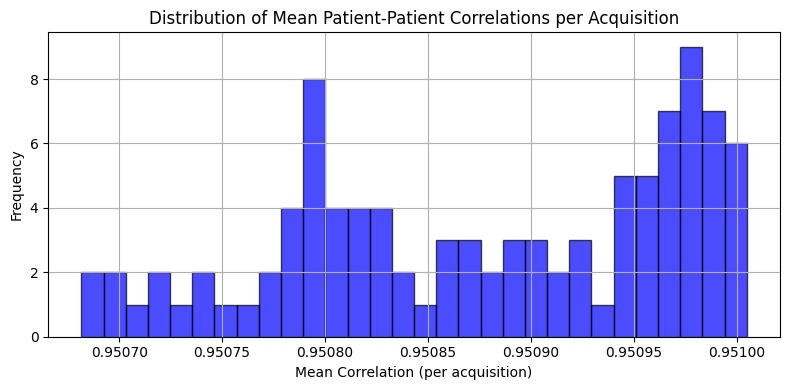


Highest mean patient correlation at acquisition 38: 0.951
Lowest mean patient correlation at acquisition 16: 0.951


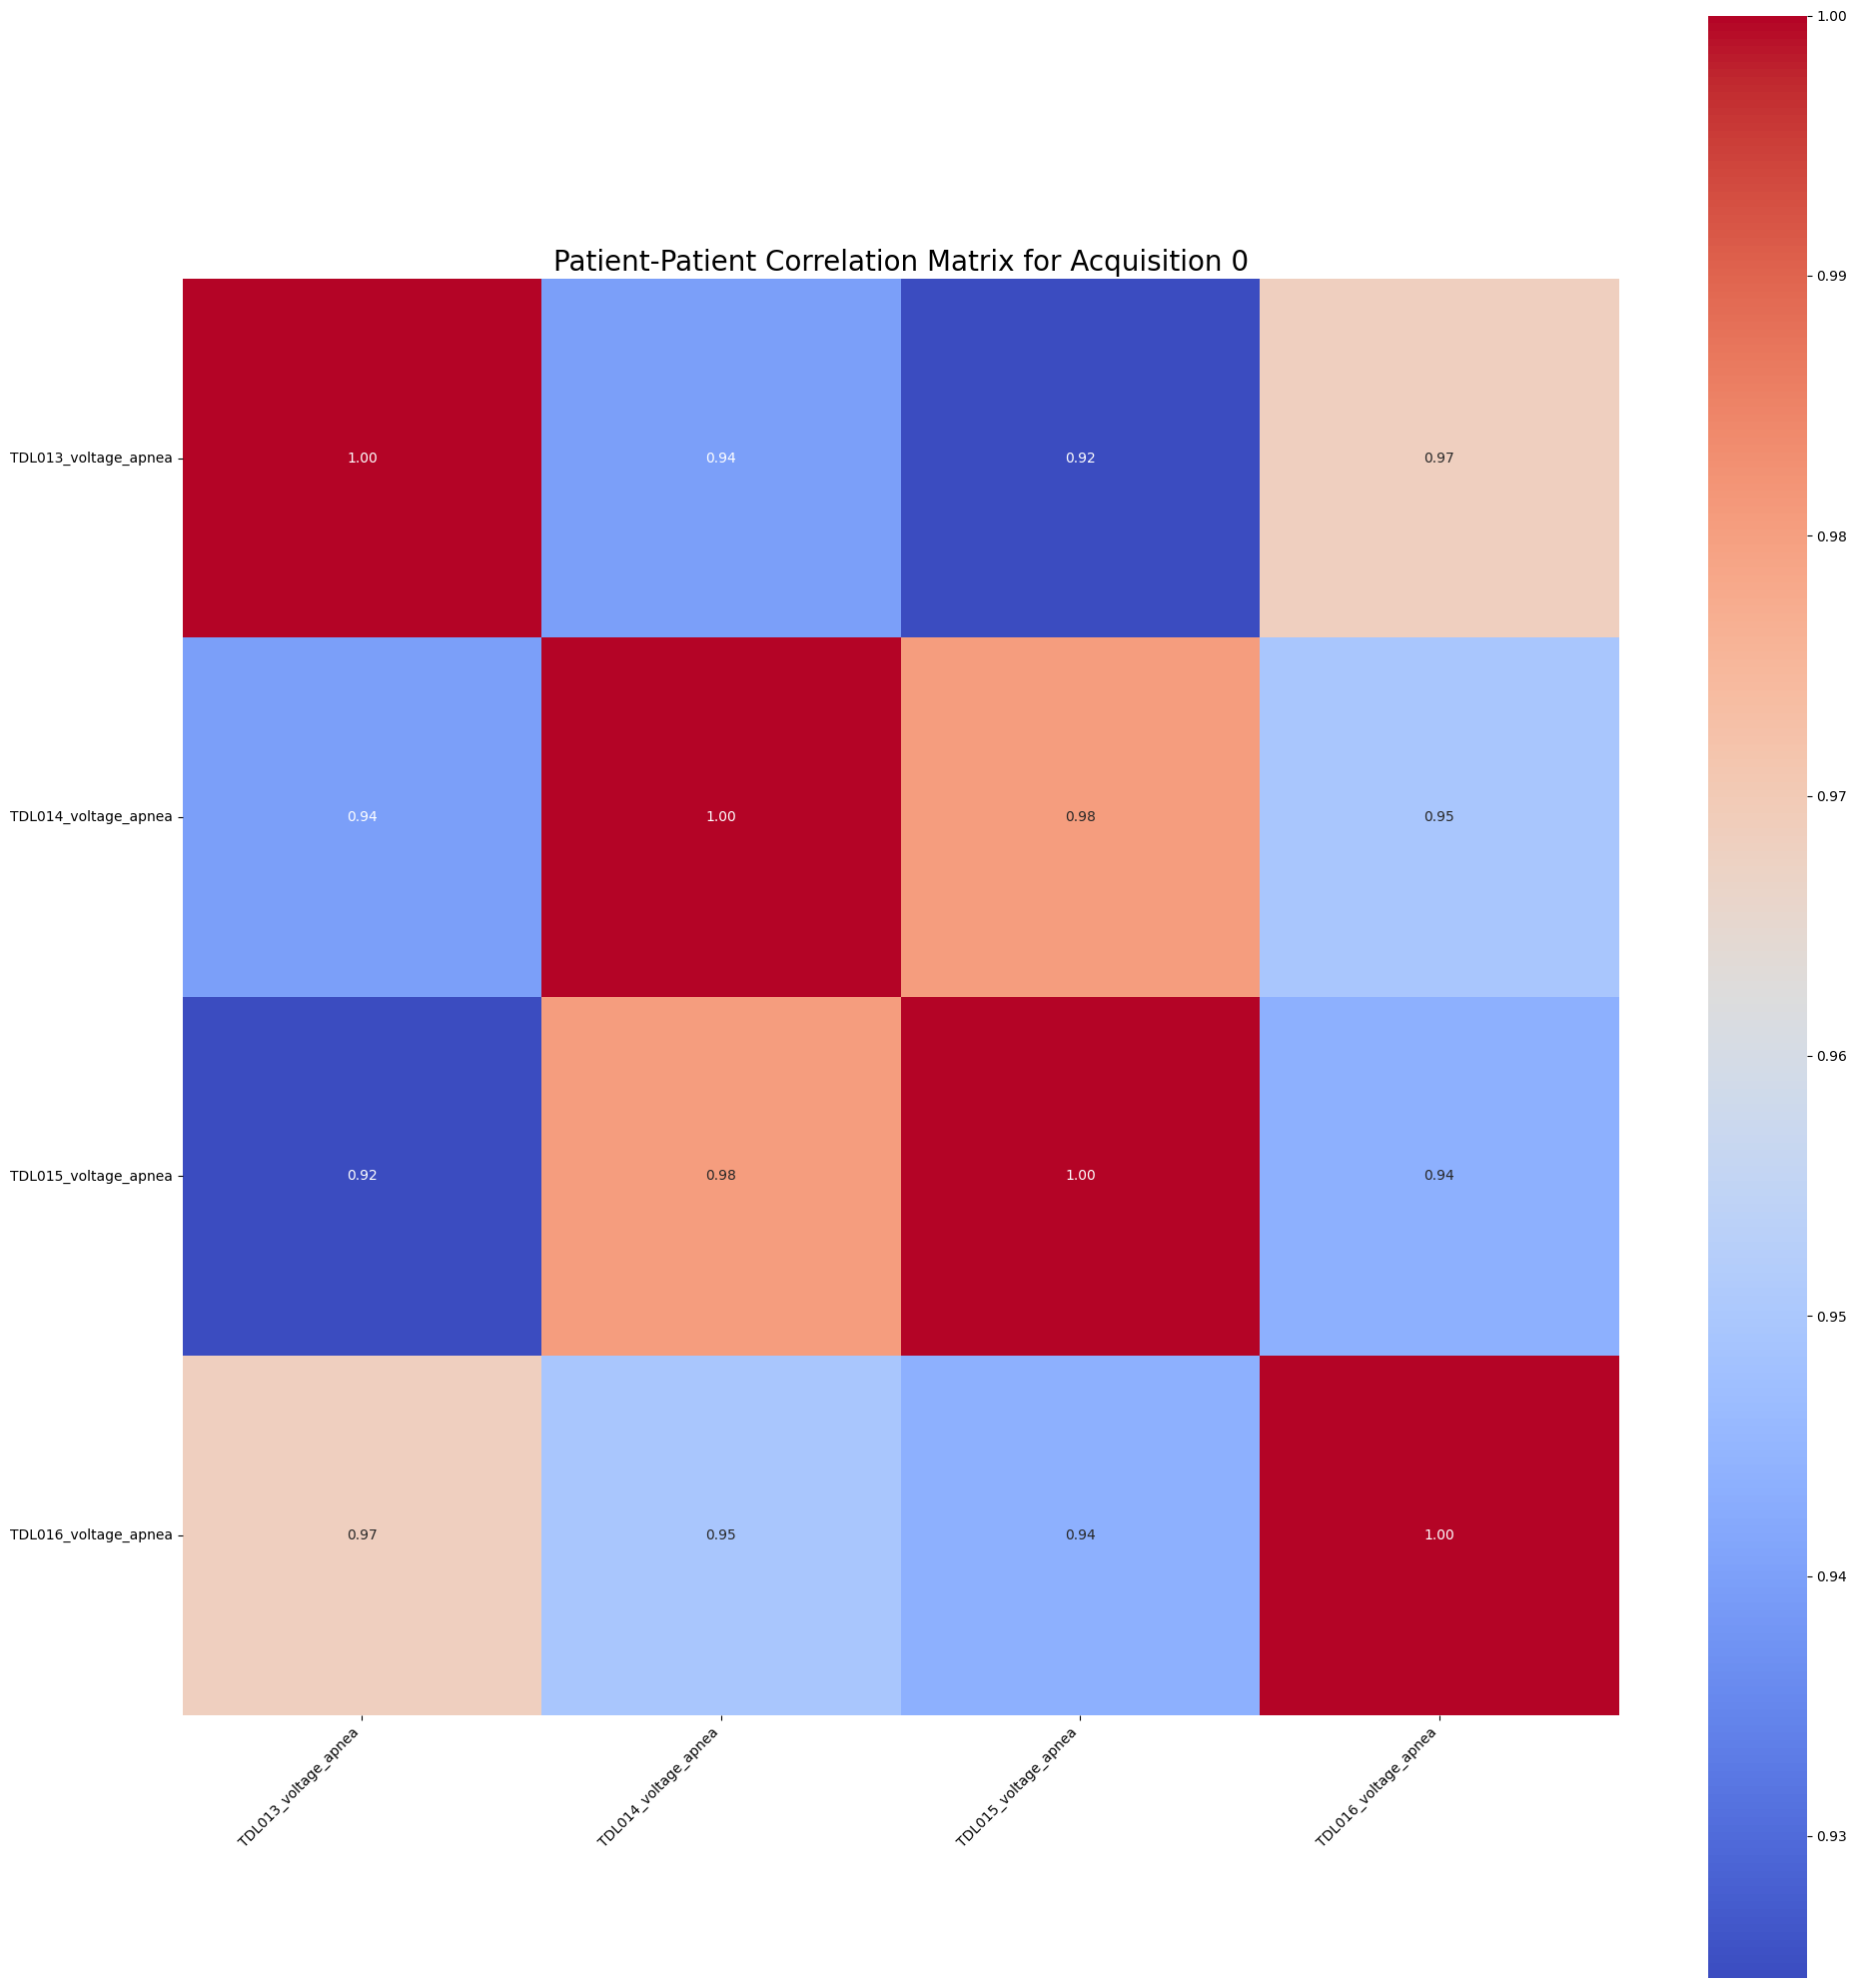

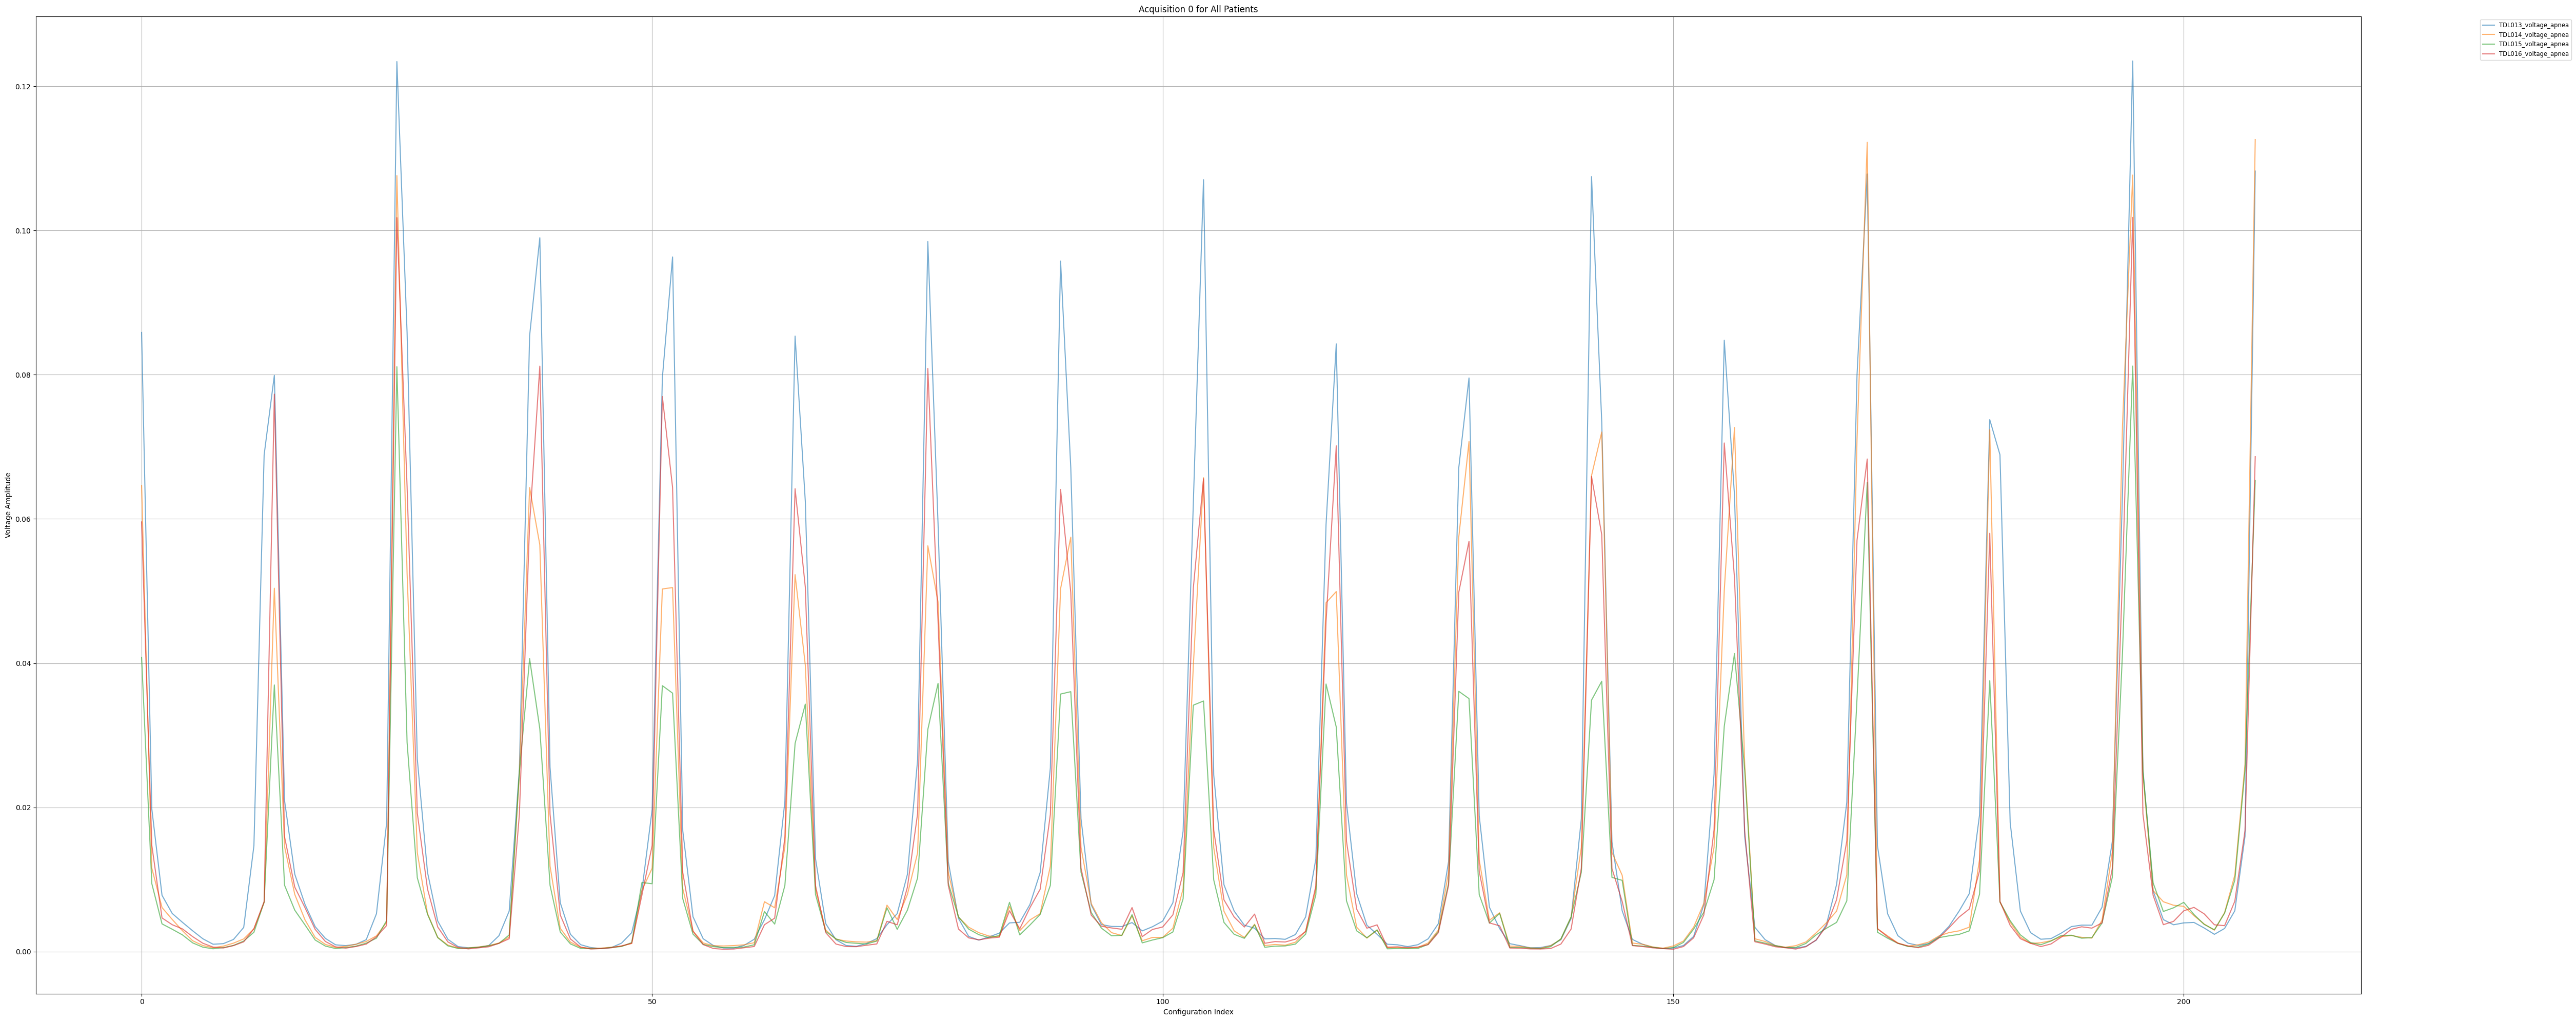

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def main():
    # Path to the folder containing patient CSV files
    input_folder = r"data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea"  # Change this as needed

    # Parameters to select subsets
    max_patients = 45       # Number of patients to consider
    max_acquisitions = 100  # Number of acquisitions to consider for each patient

    # Load all CSV files
    csv_files = glob.glob(os.path.join(input_folder, "*.csv"))
    if len(csv_files) < 2:
        print("Need at least two patient files to compute correlation between patients.")
        return

    # Sort files by name (optional)
    csv_files.sort()

    # Take only the first max_patients files if more are present
    csv_files = csv_files[:max_patients]

    # Load each patient's data
    data_list = []
    patient_names = []
    for file_path in csv_files:
        patient_name = os.path.splitext(os.path.basename(file_path))[0]
        df = pd.read_csv(file_path, header=None)

        # Check the number of acquisitions and truncate if needed
        if df.shape[0] < max_acquisitions:
            print(f"Patient {patient_name} has only {df.shape[0]} acquisitions, requested {max_acquisitions}. Using {df.shape[0]} acquisitions.")
            max_acquisitions = df.shape[0]

        df = df.iloc[:max_acquisitions, :]
        data_list.append(df)
        patient_names.append(patient_name)

    # Check all have the same shape
    shapes = {d.shape for d in data_list}
    if len(shapes) != 1:
        print("Not all files have the same shape after truncation. Cannot compare acquisitions across patients.")
        return

    n_patients = len(data_list)
    n_acquisitions, n_config = data_list[0].shape
    print(f"Number of patients considered: {n_patients}")
    print(f"Number of acquisitions considered: {n_acquisitions}")
    print(f"Number of configurations per acquisition: {n_config}")

    # Compute per-acquisition mean correlation between patients
    acquisition_correlations = []
    corr_matrices = []

    for i in range(n_acquisitions):
        # Build a DataFrame for acquisition i: columns = patients, rows = configurations
        acq_data = pd.DataFrame({patient_names[j]: data_list[j].iloc[i, :] for j in range(n_patients)})

        # Compute correlation between patients for this acquisition
        corr_matrix = acq_data.corr()
        corr_matrices.append(corr_matrix)

        # Extract upper triangle (excluding diagonal) to compute mean correlation
        triu_indices = np.triu_indices(n_patients, k=1)
        upper_values = corr_matrix.values[triu_indices]
        mean_corr = np.mean(upper_values)
        acquisition_correlations.append(mean_corr)

    acquisition_correlations = np.array(acquisition_correlations)

    # Compute more metrics
    mean_corr = np.mean(acquisition_correlations)
    median_corr = np.median(acquisition_correlations)
    std_corr = np.std(acquisition_correlations)
    q1, q3 = np.percentile(acquisition_correlations, [25, 75])

    print("\nSummary metrics for per-acquisition patient correlations:")
    print(f"Mean correlation: {mean_corr:.3f}")
    print(f"Median correlation: {median_corr:.3f}")
    print(f"Standard deviation: {std_corr:.3f}")
    print(f"1st quartile (Q1): {q1:.3f}")
    print(f"3rd quartile (Q3): {q3:.3f}")

    # Plot the distribution of mean correlations per acquisition
    plt.figure(figsize=(8,4))
    plt.hist(acquisition_correlations, bins=30, alpha=0.7, edgecolor='black', color='blue')
    plt.title("Distribution of Mean Patient-Patient Correlations per Acquisition")
    plt.xlabel("Mean Correlation (per acquisition)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Identify best and worst acquisitions
    best_acq_idx = acquisition_correlations.argmax()
    worst_acq_idx = acquisition_correlations.argmin()
    print(f"\nHighest mean patient correlation at acquisition {best_acq_idx}: {acquisition_correlations[best_acq_idx]:.3f}")
    print(f"Lowest mean patient correlation at acquisition {worst_acq_idx}: {acquisition_correlations[worst_acq_idx]:.3f}")

    # Plot correlation matrix for the first acquisition as a heatmap
    if n_acquisitions > 0:
        acq_idx_to_plot = 0  # for example, the first acquisition

        # Adjust figure size based on the number of patients
        # For many patients, make the figure larger
        fig_size_factor = max(20, n_patients / 2)  # Increase size with number of patients
        plt.figure(figsize=(fig_size_factor, fig_size_factor))

        # Annot and format
        sns.heatmap(corr_matrices[acq_idx_to_plot], annot=True, fmt=".2f", cmap='coolwarm',
                    xticklabels=patient_names, yticklabels=patient_names, 
                    cbar=True, square=True)

        plt.title(f"Patient-Patient Correlation Matrix for Acquisition {acq_idx_to_plot}", fontsize=20)
        plt.xticks(rotation=45, ha='right')  # Rotate patient names
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Plot the selected acquisition for all patients
        plt.figure(figsize=(50,20))
        for p_idx in range(n_patients):
            acquisition_data = data_list[p_idx].iloc[acq_idx_to_plot, :].values
            plt.plot(acquisition_data, alpha=0.6, label=patient_names[p_idx])
        plt.title(f"Acquisition {acq_idx_to_plot} for All Patients")
        plt.xlabel("Configuration Index")
        plt.ylabel("Voltage Amplitude")
        plt.grid(True)

        # If too many legends, they might not fit well
        # Move legend outside or reduce font size
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
        plt.tight_layout()
        plt.show()

    # Optionally, save the per-acquisition correlations
    # results_df = pd.DataFrame({"Acquisition_Index": range(n_acquisitions), "Mean_Correlation": acquisition_correlations})
    # results_df.to_csv("patient_patient_acquisition_correlations.csv", index=False)

if __name__ == "__main__":
    main()


Number of acquisitions per patient: 3600
Number of configurations (columns): 208

Correlation per acquisition between the two patients:
      Acquisition_Index  Correlation
0                     0    -0.993788
1                     1    -0.993564
2                     2    -0.993151
3                     3    -0.993022
4                     4    -0.993188
...                 ...          ...
3595               3595    -0.996272
3596               3596    -0.996146
3597               3597    -0.996129
3598               3598    -0.996151
3599               3599    -0.996035

[3600 rows x 2 columns]

Mean correlation across all acquisitions: -0.993 ± 0.002

Most correlated acquisition: 69 (corr = -0.986)
Least correlated acquisition: 3595 (corr = -0.996)


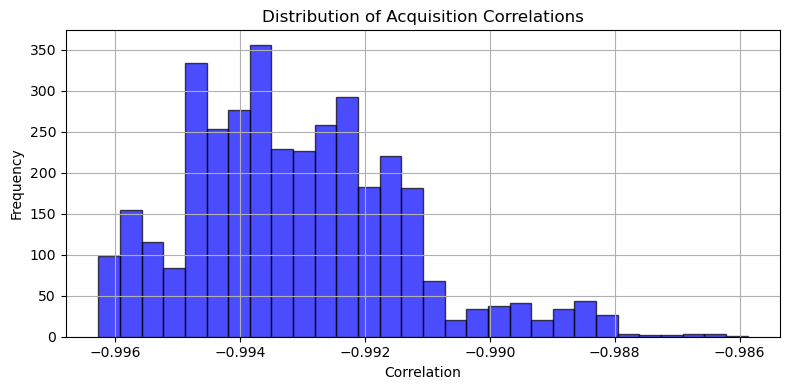

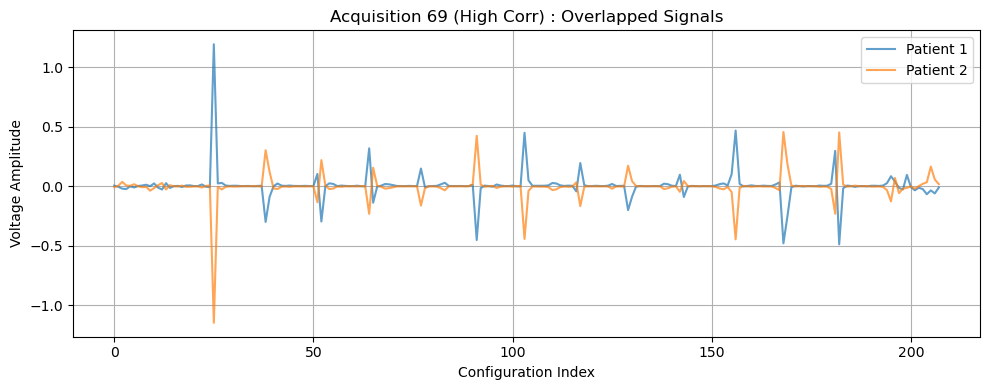

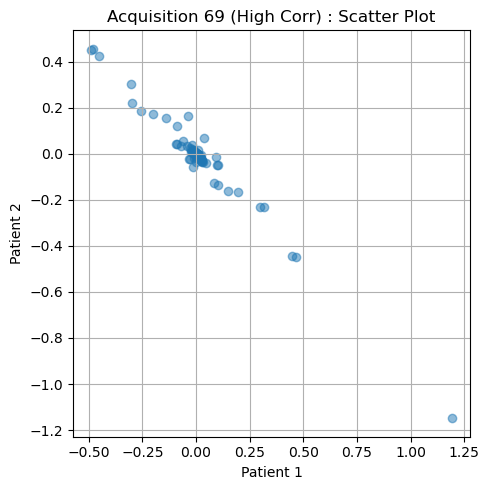

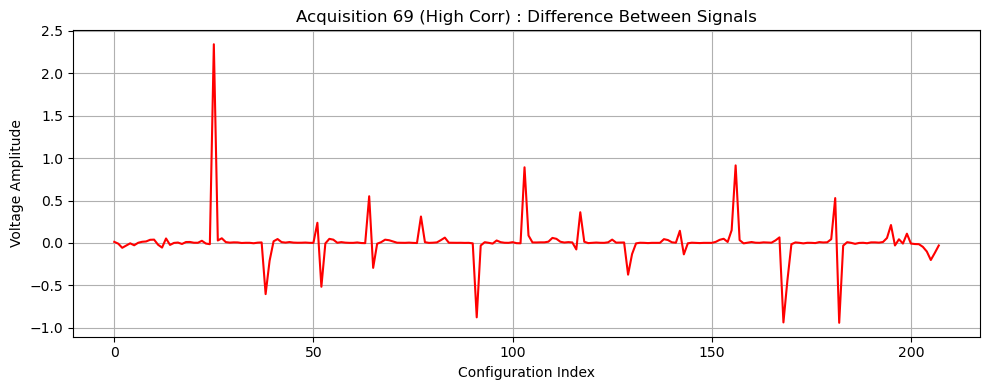

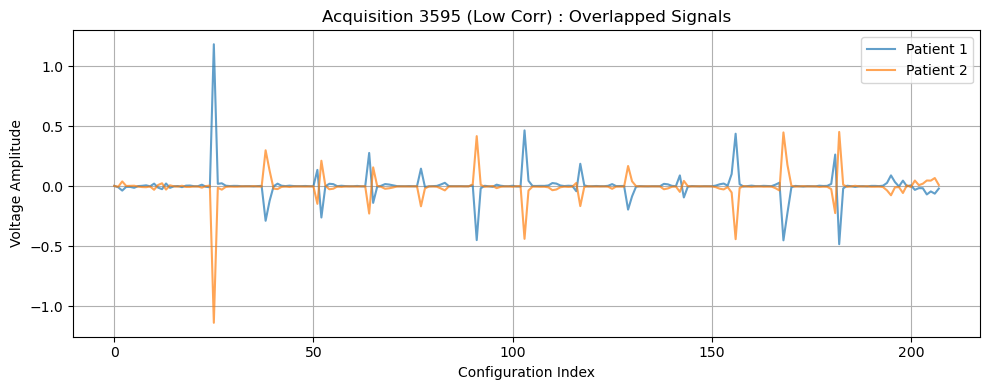

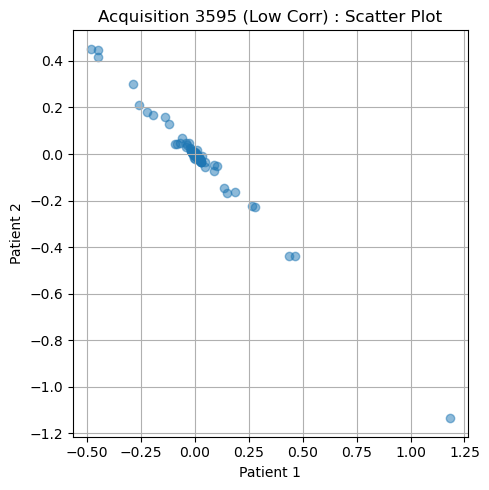

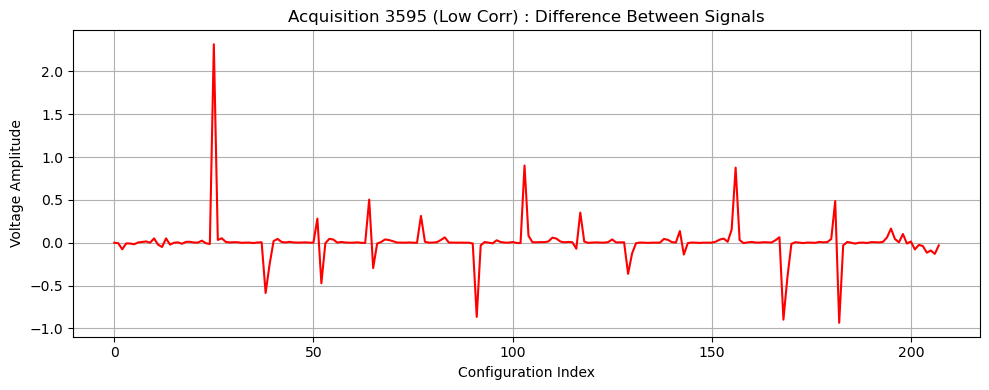

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

def plot_signals_and_difference(signal_p1, signal_p2, title_prefix=""):
    """
    Displays 3 plots:
    - Both signals overlapped
    - A scatter plot (signal_p1 vs signal_p2)
    - The difference (signal_p1 - signal_p2)
    """
    # Plot 1: Overlapped signals
    plt.figure(figsize=(10, 4))
    plt.plot(signal_p1, label='Patient 1', alpha=0.7)
    plt.plot(signal_p2, label='Patient 2', alpha=0.7)
    plt.title(f"{title_prefix} : Overlapped Signals")
    plt.xlabel("Configuration Index")
    plt.ylabel("Voltage Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: Scatter plot
    plt.figure(figsize=(5, 5))
    plt.scatter(signal_p1, signal_p2, alpha=0.5)
    plt.title(f"{title_prefix} : Scatter Plot")
    plt.xlabel("Patient 1")
    plt.ylabel("Patient 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 3: Difference
    difference = signal_p1 - signal_p2
    plt.figure(figsize=(10, 4))
    plt.plot(difference, label='Patient 1 - Patient 2', color='red')
    plt.title(f"{title_prefix} : Difference Between Signals")
    plt.xlabel("Configuration Index")
    plt.ylabel("Voltage Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    # Specify paths to your two patient's CSV files
    file_patient_1  = "C:/Users/carlos/Documents/data_displaid/data_from_fred_11-11-2024_organized/Data Raw Voltage/20241127_Fred_skip0_60fps_100khz_10mA_Minute2.csv"
    file_patient_2  = "C:/Users/carlos/Documents/data_displaid/data_from_fred_11-11-2024_organized/Data Raw Voltage/20241127_Fred_skip0_60fps_100khz_10mA_Minute7.csv"


    # Load the data
    patient_1_data = pd.read_csv(file_patient_1, header=None)
    patient_2_data = pd.read_csv(file_patient_2, header=None)

    # Check dimensions
    if patient_1_data.shape != patient_2_data.shape:
        print("The two files do not have the same dimensions. Cannot compare acquisitions directly.")
        return

    n_acquisitions, n_config = patient_1_data.shape
    print(f"Number of acquisitions per patient: {n_acquisitions}")
    print(f"Number of configurations (columns): {n_config}")

    # Compute correlation per acquisition
    # For each acquisition (row), we have a vector of 'n_config' configurations.
    # We'll compute the correlation between these two vectors (patient_1 vs patient_2).
    acquisition_correlations = []
    for i in range(n_acquisitions):
        signal_p1 = patient_1_data.iloc[i, :]
        signal_p2 = patient_2_data.iloc[i, :]
        
        # Compute Pearson correlation for this acquisition
        corr_value = signal_p1.corr(signal_p2)
        acquisition_correlations.append(corr_value)

    # Create a DataFrame of correlations
    correlations_df = pd.DataFrame({"Acquisition_Index": range(n_acquisitions), "Correlation": acquisition_correlations})
    print("\nCorrelation per acquisition between the two patients:")
    print(correlations_df)

    # Compute a summary metric: e.g., mean correlation
    mean_corr = correlations_df['Correlation'].mean()
    std_corr = correlations_df['Correlation'].std()
    print(f"\nMean correlation across all acquisitions: {mean_corr:.3f} ± {std_corr:.3f}")

    # Identify the most and least correlated acquisitions
    max_corr_idx = correlations_df['Correlation'].idxmax()
    min_corr_idx = correlations_df['Correlation'].idxmin()

    print(f"\nMost correlated acquisition: {max_corr_idx} (corr = {correlations_df.loc[max_corr_idx, 'Correlation']:.3f})")
    print(f"Least correlated acquisition: {min_corr_idx} (corr = {correlations_df.loc[min_corr_idx, 'Correlation']:.3f})")

    # Plotting distributions
    plt.figure(figsize=(8, 4))
    plt.hist(acquisition_correlations, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title("Distribution of Acquisition Correlations")
    plt.xlabel("Correlation")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot signals for the most correlated acquisition
    best_signal_p1 = patient_1_data.iloc[max_corr_idx, :]
    best_signal_p2 = patient_2_data.iloc[max_corr_idx, :]
    plot_signals_and_difference(best_signal_p1, best_signal_p2, title_prefix=f"Acquisition {max_corr_idx} (High Corr)")

    # Plot signals for the least correlated acquisition
    worst_signal_p1 = patient_1_data.iloc[min_corr_idx, :]
    worst_signal_p2 = patient_2_data.iloc[min_corr_idx, :]
    plot_signals_and_difference(worst_signal_p1, worst_signal_p2, title_prefix=f"Acquisition {min_corr_idx} (Low Corr)")

if __name__ == "__main__":
    main()


Number of acquisitions: 3600
Number of configurations: 208


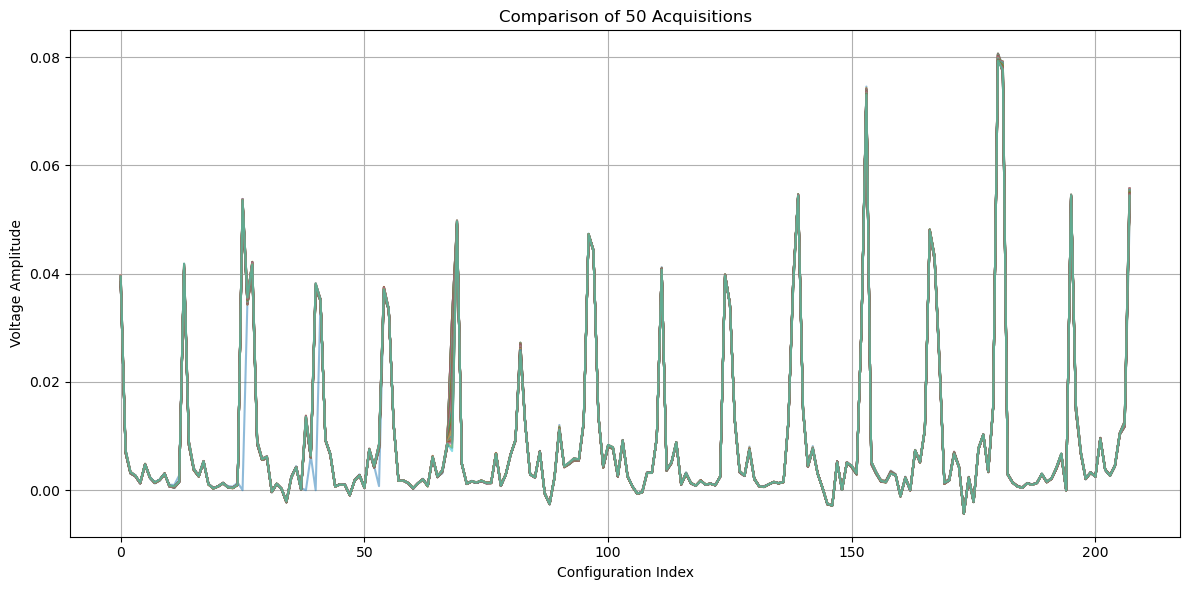

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def main():
    # Path to your single patient's CSV file
    file_patient =  r"B:\data_displaid\data_from_fred_21-12-2025_organized_train_elec_remov\Data Raw Voltage\20250221_Fred_skip0_60fps_100khz_10mA_Minute12.csv"

    
    # Load data (no header assumed)
    # Shape: (N_acquisitions, N_configurations), e.g. (3600, 208)
    patient_data = pd.read_csv(file_patient, header=None)
    
    n_acquisitions, n_config = patient_data.shape
    print(f"Number of acquisitions: {n_acquisitions}")
    print(f"Number of configurations: {n_config}")
    
    # To avoid plotting all acquisitions (which might be too crowded), select a subset
    # For example, first 50 acquisitions:
    subset_size = 50
    if n_acquisitions > subset_size:
        data_subset = patient_data.iloc[:subset_size, :]
    else:
        data_subset = patient_data
    
    # Plot each acquisition as a line
    # Each row is an acquisition, so we'll plot them row by row.
    plt.figure(figsize=(12, 6))
    
    for i in range(data_subset.shape[0]):
        # Extract one acquisition (row) as a 1D array
        acquisition = data_subset.iloc[i, :].values
        plt.plot(acquisition, alpha=0.5)  # alpha for some transparency
    
    plt.title(f"Comparison of {data_subset.shape[0]} Acquisitions")
    plt.xlabel("Configuration Index")
    plt.ylabel("Voltage Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # If you really want to see all acquisitions at once, remove the subset logic and plot all:
    # But be aware it might be very cluttered.
    # for i in range(n_acquisitions):
    #     plt.plot(patient_data.iloc[i, :].values, alpha=0.5)

if __name__ == "__main__":
    main()


Patient 1: 3600 acquisitions, 208 configurations
Patient 2: 3600 acquisitions, 208 configurations
Patient 3: 3600 acquisitions, 208 configurations


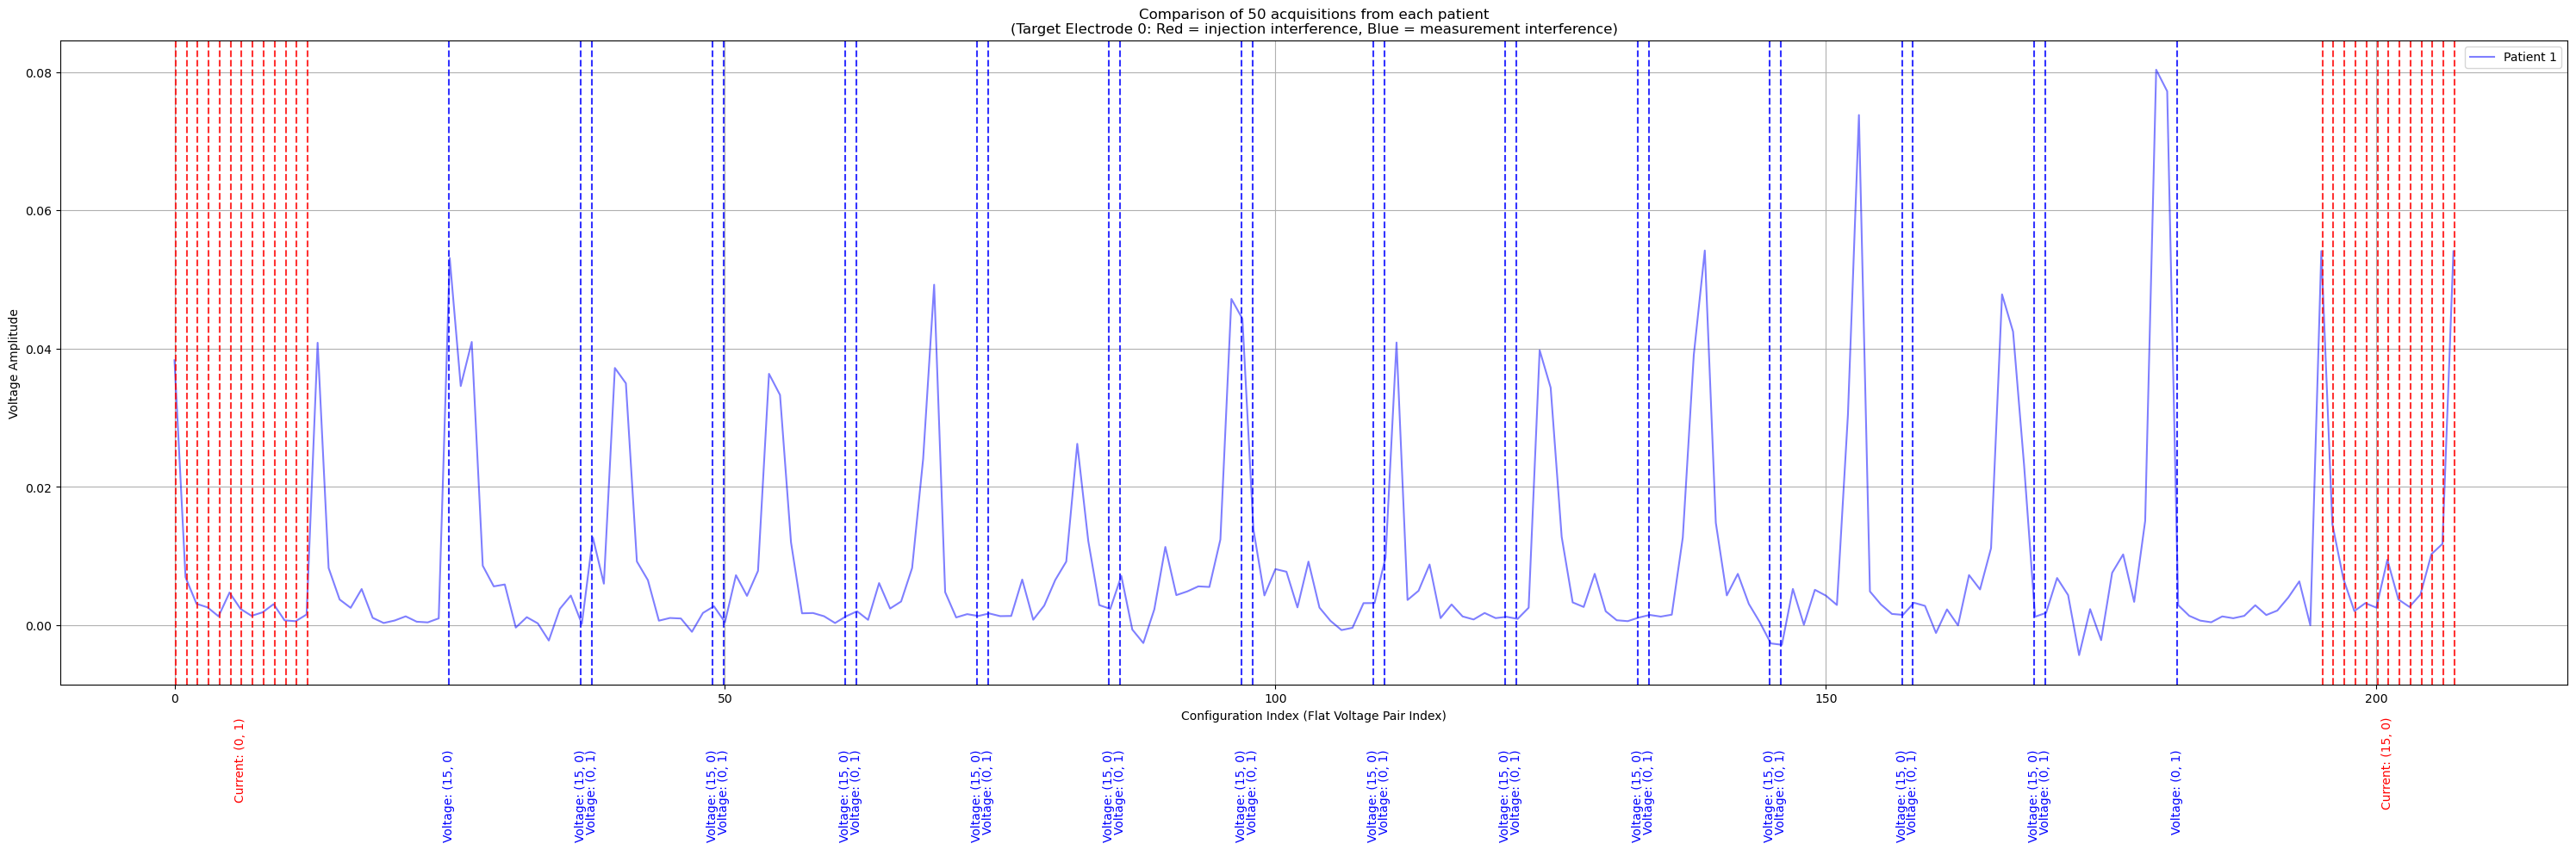

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def create_voltage_pairs_mapping(n_electrodes=16):
    """
    Creates a nested mapping for an adjacent configuration.
    For each current injection pair (electrodes i and i+1 mod n_electrodes),
    the voltage measurement pairs are defined as the 13 adjacent pairs:
      ((i+2) mod n, (i+3) mod n), ((i+3) mod n, (i+4) mod n), ..., ((i+14) mod n, (i+15) mod n).
    Returns a list of dictionaries, each with:
      "current": a tuple representing the injection pair,
      "voltage": a list of 13 tuples representing the voltage measurement pairs.
    """
    measurements_per_injection = 13
    mapping = []
    for i in range(n_electrodes):
        current_injection = (i, (i + 1) % n_electrodes)
        voltage_measurements = []
        for j in range(measurements_per_injection):
            pair = ((i + 2 + j) % n_electrodes, (i + 3 + j) % n_electrodes)
            voltage_measurements.append(pair)
        mapping.append({"current": current_injection, "voltage": voltage_measurements})
    return mapping

def main():
    # Paths to your three datasets
    file_patient_1 = r"B:\data_displaid\data_from_fred_21-12-2025_organized_train_elec_remov\Data Raw Voltage\20250221_Fred_skip0_60fps_100khz_10mA_Minute12.csv"
    file_patient_2 = r"B:\data_displaid\data_from_fred_21-12-2025_organized_train_elec_remov\Data Raw Voltage\20250221_Fredmu0.0sigma0.0rho0.0_skip0_60fps_100khz_10mA_Minute1.csv"
    file_patient_3 = r"B:\data_displaid\data_from_jonathan_decolle_organized\Data Raw Voltage\20250325_Jonathan_skip0_60fps_100khz_10mA_Minute8_elec2_decolle.csv"  # Replace with actual path

    # Load the three datasets
    patient_1_data = pd.read_csv(file_patient_1, header=None)
    patient_2_data = pd.read_csv(file_patient_2, header=None)
    patient_3_data = pd.read_csv(file_patient_3, header=None)

    # Check if all datasets have the same number of configurations (columns)
    if not (patient_1_data.shape[1] == patient_2_data.shape[1] == patient_3_data.shape[1]):
        print("Datasets have different numbers of configurations (columns).")
        print("Make sure they match if you want a direct comparison.")
        return

    n_config = patient_1_data.shape[1]
    print(f"Patient 1: {patient_1_data.shape[0]} acquisitions, {n_config} configurations")
    print(f"Patient 2: {patient_2_data.shape[0]} acquisitions, {n_config} configurations")
    print(f"Patient 3: {patient_3_data.shape[0]} acquisitions, {n_config} configurations")

    # Choose subset size for each dataset
    subset_size = 50  # Change this if desired

    # Extract subsets (first subset_size acquisitions)
    data_subset_1 = patient_1_data.iloc[:subset_size, :] if patient_1_data.shape[0] > subset_size else patient_1_data
    data_subset_2 = patient_2_data.iloc[:subset_size, :] if patient_2_data.shape[0] > subset_size else patient_2_data
    data_subset_3 = patient_3_data.iloc[:subset_size, :] if patient_3_data.shape[0] > subset_size else patient_3_data

    # For clarity, plot one acquisition (adjust row index as needed)
    plt.figure(figsize=(30, 10))
    row_idx = 20  # example row index

    # Plot dataset 1 acquisition in blue
    if row_idx < data_subset_1.shape[0]:
        plt.plot(data_subset_1.iloc[row_idx, :].values, alpha=0.5, color='blue', label='Patient 1')
    # (Optional) Plot dataset 2 if desired (example commented out)
    # if row_idx < data_subset_2.shape[0]:
    #     plt.plot(data_subset_2.iloc[row_idx, :].values, alpha=0.5, color='red', label='Patient 2')
    # Plot dataset 3 acquisition in green
    # if row_idx < data_subset_3.shape[0]:
    #     plt.plot(data_subset_3.iloc[row_idx, :].values, alpha=0.5, color='green', label='Patient 3')

    # ----------------- Marking Affected Configurations -----------------


    # Create the nested mapping for injection and voltage pairs
    mapping = create_voltage_pairs_mapping(n_electrodes=16)
    measurements_per_injection = 13

    ax = plt.gca()
    ymin, ymax = ax.get_ylim()
    red_offset = (ymax - ymin) * 0.05   # offset for red annotations
    blue_offset = (ymax - ymin) * 0.10  # further offset for blue annotations


    # Set the target electrode (change as needed)
    target_electrode = 0

    # Loop over each block (each injection configuration)
    for block_idx, block in enumerate(mapping):
        base_index = block_idx * measurements_per_injection

        # If the injection (current) pair contains the target electrode, mark with red vertical lines
        if target_electrode in block["current"]:
            for j in range(measurements_per_injection):
                flat_idx = base_index + j
                plt.axvline(x=flat_idx + 0.1, color='red', linestyle='--', alpha=0.8)
            # Annotate once per block (red annotation)
            mid_idx = base_index + measurements_per_injection // 2
            plt.text(mid_idx, ymin - red_offset, f"Current: {block['current']}",
                     color='red', ha='center', va='top', fontsize=10, rotation=90)
        
        # Now check each measurement pair in this block.
        for j, meas_pair in enumerate(block["voltage"]):
            flat_idx = base_index + j
            if target_electrode in meas_pair:
                plt.axvline(x=flat_idx - 0.1, color='blue', linestyle='--', alpha=0.8)
                # Annotate each blue line with the voltage configuration
                plt.text(flat_idx - 0.1, ymin - blue_offset, f"Voltage: {meas_pair}",
                         color='blue', ha='center', va='top', fontsize=10, rotation=90)
    # ---------------------------------------------------------------------

    plt.title(f"Comparison of {subset_size} acquisitions from each patient\n"
              f"(Target Electrode {target_electrode}: Red = injection interference, Blue = measurement interference)")
    plt.xlabel("Configuration Index (Flat Voltage Pair Index)")
    plt.ylabel("Voltage Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
s